In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import time
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')


In [3]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')


Length of text: 1115394 characters


In [4]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


In [5]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)


In [6]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids


<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [7]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)


In [8]:
seq_length = 100


In [9]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))


tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [10]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)


for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())


b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [11]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text


In [12]:
dataset = sequences.map(split_input_target)


In [13]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())


Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [14]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [15]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024


In [16]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru1 = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.gru2 = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = [self.gru1.get_initial_state(x), self.gru2.get_initial_state(x)]
    x, state1 = self.gru1(x, initial_state=states[0], training=training)
    x, state2 = self.gru2(x, initial_state=states[1], training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, [state1, state2]
    else:
      return x


In [17]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)


In [18]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [19]:
model.summary()


Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 gru_1 (GRU)                 multiple                  6297600   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 10,320,450
Trainable params: 10,320,450
Non-trainable params: 0
_________________________________________________________________


In [20]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()


In [21]:
sampled_indices


array([64,  2, 11, 51, 42, 29,  3, 38, 58, 43, 59, 56, 46, 39, 62, 21, 61,
       50,  9,  4,  7, 65, 20, 17, 43, 45, 33, 26, 25, 41, 18,  1, 15,  6,
        2, 24,  0, 33, 60, 29, 19, 53, 37,  9, 13, 50, 30, 11, 62, 32, 62,
       14, 43, 50, 28, 50, 25, 16, 24, 18, 36,  0, 12, 64, 50, 65, 50, 42,
        8, 40, 25, 33,  6, 37, 53, 63, 63,  4, 45, 43, 28, 55, 13, 14, 58,
       21,  5,  8, 60, 51, 12, 48,  3,  1, 34, 32, 55, 33, 31,  6])

In [22]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())


Input:
 b"thee would prove itself a bawd:\n'Tis best thou diest quickly.\n\nCLAUDIO:\nO hear me, Isabella!\n\nDUKE V"

Next Char Predictions:
 b"y :lcP!YsdtqgZwHvk.$,zGDdfTMLbE\nB' K[UNK]TuPFnX.?kQ:wSwAdkOkLCKEW[UNK];ykzkc-aLT'Xnxx$fdOp?AsH&-ul;i!\nUSpTR'"


In [23]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)


In [24]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)


Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1895056, shape=(), dtype=float32)


In [25]:
tf.exp(example_batch_mean_loss).numpy()


65.99016

In [26]:
model.compile(optimizer='adam', loss=loss)


In [27]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)


In [28]:
EPOCHS = 30


In [29]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])


Epoch 1/30
172/172 [==============================] - 44s 232ms/step - loss: 2.6135
Epoch 2/30
172/172 [==============================] - 41s 232ms/step - loss: 1.8111
Epoch 3/30
172/172 [==============================] - 41s 234ms/step - loss: 1.5462
Epoch 4/30
172/172 [==============================] - 41s 234ms/step - loss: 1.4246
Epoch 5/30
172/172 [==============================] - 41s 233ms/step - loss: 1.3492
Epoch 6/30
172/172 [==============================] - 41s 232ms/step - loss: 1.2940
Epoch 7/30
172/172 [==============================] - 41s 232ms/step - loss: 1.2450
Epoch 8/30
172/172 [==============================] - 41s 232ms/step - loss: 1.1990
Epoch 9/30
172/172 [==============================] - 41s 230ms/step - loss: 1.1504
Epoch 10/30
172/172 [==============================] - 41s 231ms/step - loss: 1.0992
Epoch 11/30
172/172 [==============================] - 42s 235ms/step - loss: 1.0411
Epoch 12/30
172/172 [==============================] - 41s 232ms/step - lo

In [30]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    if states is not None:
        states = tf.identity(states)  # Makes a copy of 'states'
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states


In [31]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)


In [32]:
start = time.time()
states = None
next_char = tf.constant(['PEANUT:'])
result = [next_char]

for n in range(2000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)


PEANUT:
Look down so long as it is strange
In stamp of Richard charite to have some conference with his brother.
And that is, to say this?

LUCIO:
My lord; here's no truth at us.

CLARENCE:
A little fire of doors are store of Richmond.

ISABELLA:
I am bound to resolve you hence,
To hear what holy to you in summer's son,
I'll be the queen there's son, and made peace
with her, or she
with me to make him a merited bul,
On idle pities for their loved,
That from his horse will have me hell make crook'd
To the self among then he this smole are took.

QUEEN:
To meet that winter shows a show,
Nor mean you shout, for unuaby'd will; but you
Have to begged thee in a tailor of a mother,
And all the double drums and eyes that over-looked
Would be hurl'd up to this shoe-win and as crown
Till he needs no better.

DUKE VINCENTIO:
This is most like, this is a part; for the enemy
Is all unpossible.

GREEN:
Besides, our neighbours: I will his majesty
To strut before a way from been.

HORTENSIO:
How shoul

In [ ]:
states

In [ ]:
tf.saved_model.save(one_step_model, 'one_step_gru')

In [ ]:
one_step_reloaded = tf.saved_model.load('one_step_gru')


In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(500):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))


In [ ]:
history

In [ ]:
print(history.history.keys())

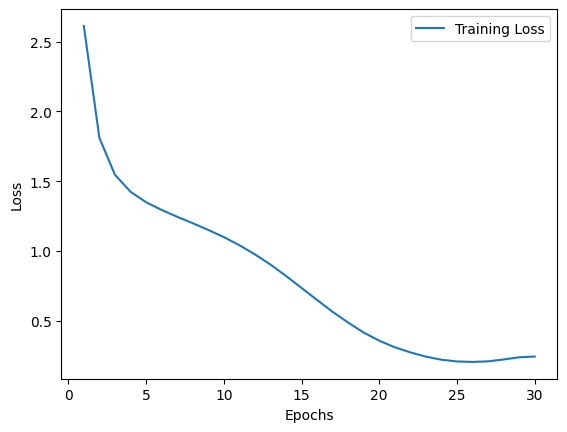

In [33]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()